# Лабораторная работа № 5
## Сети с обратными связями

`Цель работы:` исследование свойств сетей Хопфилда, Хэмминга и Элмана, алгоритмов обучения, а также применение сетей в задачах распознавания статических и динамических образов.

|Студент| Мариничев И.А.|
|-|-|
|**Группа**| **М8О-408Б-19**|
|**Вариант**| **5**|

Импортируем всё необходимое

In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from tqdm import tqdm

import matplotlib.pyplot as plt

Зададим значения длительности, соответствующие варианту 

In [2]:
class Duration:
    def __init__(self) -> None:
        self.r1 = 3
        self.r2 = 3
        self.r3 = 4

In [3]:
R = Duration()

Зададим комбинированный сигнал, в котором участкам `p1` ставится в соответствие 1, а участкам `p2` -1

In [4]:
def make_signals(r1, r2, r3):
    k1 = np.arange(0, 1, 0.025) 
    k2 = np.arange(0.74, 3.14, 0.025)

    p1 =  np.sin(4 * np.pi * k1) 
    p2 =  1.5 * np.sin(np.sin(k2) * k2**2) - 0.5

    t1 = -1 * np.ones(len(p1))
    t2 = np.ones(len(p2))

    assert len(k1) == len(p1) and len(k1) == len(t1)
    assert len(k2) == len(p2) and len(k2) == len(t2)

    signal = np.concatenate((np.tile(p1, r1), p2, np.tile(p1, r2), p2, np.tile(p1, r3), p2))
    labels = np.concatenate((np.tile(t1, r1), t2, np.tile(t1, r2), t2, np.tile(t1, r3), t2))

    return signal, labels

In [5]:
signal, labels = make_signals(R.r1, R.r2, R.r3)

Зададим набор данных для обучения

In [6]:
def get_train_data(signal, labels, window):
    signal_seq = [np.array(signal[i:i+window], dtype=np.float32) for i in range(len(signal) - window)]
    labels_seq = [np.array(labels[i:i+window], dtype=np.float32) for i in range(len(labels) - window)]
    output = [(s, l) for s, l in zip(signal_seq, labels_seq)]
    return output

In [7]:
WINDOW = 5

train_dataset = get_train_data(signal, labels, WINDOW)
train_loader = DataLoader(train_dataset, shuffle=False)

Создадим класс слоя сети Элмана

In [8]:
class ElmanLayer(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super(ElmanLayer, self).__init__()
        self.weights1 = nn.Parameter(torch.randn(in_features, out_features))
        self.weights2 = nn.Parameter(torch.randn(out_features, out_features))
        self.bias = nn.Parameter(torch.randn(out_features))

    def reset(self):
        if hasattr(self, "prev"):
            delattr(self, "prev")

    def forward(self, input: torch.Tensor):
        out = torch.matmul(input, self.weights1)
        out = torch.add(out, self.bias)
        if hasattr(self, "prev"):
            d = torch.matmul(self.prev, self.weights2)
            out = torch.add(out, d)
        out = torch.tanh(out) # outp -> [-1, 1]
        self.prev = out.clone().detach()
        return out

Наша сеть будет принимать на вход количество точек в окне, скрытый слой состоит из 8 нейронов, согласно условию

In [9]:
elman_net = nn.Sequential (
    ElmanLayer(in_features = WINDOW, out_features = 8),
    nn.Linear(in_features = 8, out_features = WINDOW)
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(elman_net.parameters())

Определим функцию обучения на батчах

In [10]:
def fit(model, train_loader, criterion, optimizer, epochs):
    losses = []

    running_loss = 0.0
    processed_data = 0

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            model[0].reset() # удаляем старый контекст перед началом эпохи
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outp = model(inputs)

                loss = criterion(outp, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                processed_data += inputs.size(0)

            train_loss = running_loss / processed_data
            losses.append(train_loss)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=loss))
    return losses

А также определим функцию предсказания

In [11]:
def predict(model, test_loader):
    with torch.no_grad():
        model.eval()
        model[0].reset() # удаляем старый контекст

        outp = []
        for x, _ in test_loader:
            outp += [model(x).detach().numpy().item(0)]
        outp = np.array(outp)

        outp[outp > 0] = 1
        outp[outp < 0] = -1
    return outp

Обучим модель

In [ ]:
losses = fit(elman_net, train_loader, loss_function, optimizer, 100)

Посмотрим на график функции потерь, вычисляющей `MSE` между исходными и полученными данными

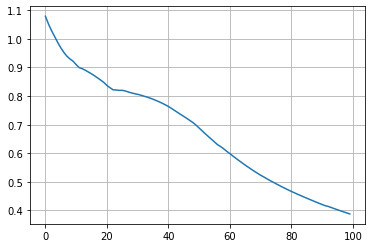

In [13]:
plt.plot(losses)
plt.grid(True, which='both')
plt.show()

Теперь соберем предсказания модели

In [14]:
labels_pred = predict(elman_net, train_loader)

Посмотрим на наш сигнал с истинными размеченными участками

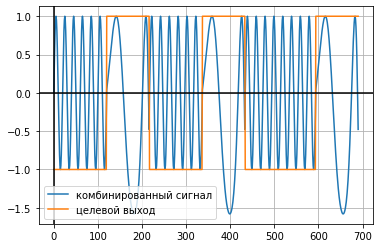

In [15]:
plt.plot(signal, label='комбинированный сигнал')
plt.plot(labels, label='целевой выход')

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.legend()
plt.show()

И посмотрим на наш сигнал с участками, размеченными сетью Элмана

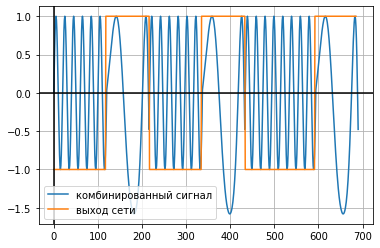

In [16]:
plt.plot(signal, label='комбинированный сигнал')
plt.plot(labels_pred, label='выход сети')

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.legend()
plt.show()

`Выводы:` в ходе данной работы была построена сеть с обратными связями (сохраняющими контекст), которая была использована для задачи распознавания динамических образов. После обучения (`100` эпох) были получены верные результаты